# Cross correlation with Planck CMB

In [2]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Making Galaxy Density HealpixMap

In [194]:
def making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    
    seen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'int'), ('KAPPA', 'float')])
    Ntot = cat.size
    Npix = np.sum(seen)
    Atot = pixarea * Npix
    ntot = Ntot *1./Atot
    ngal = N_gal *1./pixarea
    

    print 'Ntot', Ntot
    #print 'Ngal', N_gal
    print 'mean Ngal', np.mean(N_gal[seen])
    print 'Npix', Npix
    #print 'Map.size', Map.shape
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal 
    Map['WEIGHT'] = N_gal #seen #  ( ngal*1./ntot - 1.)*1./Npix
    Map['KAPPA'] =  (N_gal*1./Ntot * Npix -1.)
    #Map['WEIGHT'][unseen] = 0
    #Map['WEIGHT_RAND'] = unseen
    return Map

In [4]:
def making_healpix_density_map_boss(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    #N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    #seen = (N_gal != 0.0)
    
    mask = np.in1d(hpind, cat_ind)
    return hpind[mask]

In [5]:
def making_healpix_cmbmap(hpmap = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    #cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    #N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    seen = (hpmap > -1e+10)
    #pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('KAPPA', 'float') , ('WEIGHT', 'float') , ('WEIGHT_RAND', 'bool') ])
    print Map.shape, hpmap.size, hpind.shape
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind  
    Map['KAPPA'] = hpmap
    Map['WEIGHT'] = seen
    Map['WEIGHT_RAND'] = seen
    return Map

In [131]:
def boss_mask(cat=None, area='SGC', nside_out = 1024):

    if area is 'SGC' : 
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits')
        
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)

    elif area is 'NGC':
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits')
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)
    else : 
        print 'area keyword input : SGC or NGC'
        return 0
     
    boss_hpfrac = np.zeros(hp.nside2npix(1024), dtype = 'float')
    boss_hpfrac[boss_hpind] = 1.0
    boss_hpfrac_ud = boss_hpfrac.copy() #hp.ud_grade(boss_hpfrac, pess=True, nside_out = nside_out)
    #boss_hpfrac_ud[ boss_hpfrac_ud < 0.8] = 0
    
    boss_hpind_up = np.arange(hp.nside2npix(nside_out))
    #print boss_hpfrac
    
    
    #boss_hpfrac_ud2 = boss_hpfrac_ud.copy()
    #boss_hpfrac_ud2[ boss_hpfrac_ud > 0.8] = 0
    #hp.mollview( boss_hpfrac_ud2, max = 1, nest = False)
    
    #if cat is None : 
    #    boss_hpmask = np.zeros(hp.nside2npix(4096), dtype = 'bool')
    #    boss_hpmask[boss_hpind] = 1
    #    return boss_hpmask
    
    #elif cat is not None : 
        
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= 1024, nest= False) 
    goodind = np.in1d(hpind, boss_hpind_up[[ boss_hpfrac_ud > 0.8]])
    return cat[goodind]

In [133]:
def y1gold_mask(cat=None, nside_out = 4096):
    
    path = '/n/des/lee.5922/data/systematic_maps/'
    LSSGoldmask_hpind = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')['PIXEL']
    hpind_frac = np.zeros(hp.nside2npix(4096), dtype = 'float')
    hpind_frac[LSSGoldmask_hpind] = 1.0
    hpind_frac_ud = hpind_frac.copy() #hp.ud_grade(hpind_frac, pess=True, nside_out = nside_out)
    
    hpind_up = np.arange(hp.nside2npix(nside_out))
    
    cat_hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(cat_hpind, hpind_up[[ hpind_frac_ud > 0.8]])
    return cat[goodind]  

In [128]:
reddening_nest = esutil.io.read('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits')
reddening_ring = hp.reorder(reddening_nest['TEMPERATURE'], inp='NEST', out='RING')
reddening = rotate_hp_map(reddening_ring, coord = ['C', 'G'])
mind = np.arange(hp.nside2npix(512))
reliable_hp_mask = (reddening < 0.05/0.367)
reliable_hpind = mind[reliable_hp_mask]

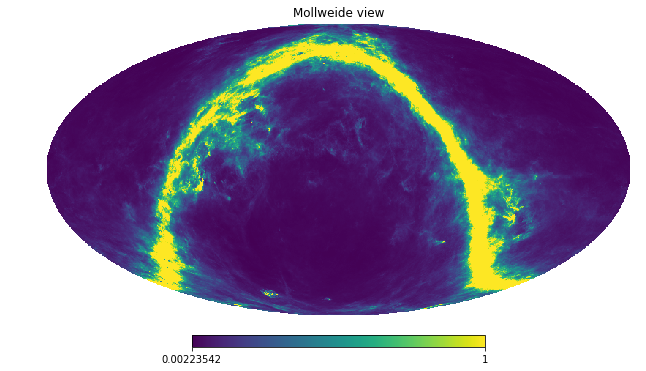

In [129]:
hp.mollview( reddening, max = 1, nest = False)

### Color correction 

### Masking Planck Map

In [153]:
import fitsio
NSIDE = 1024
cmbmap = fitsio.read('/n/des/lee.5922/data/planck_data/COM_CompMap_Lensing_2048_R1.10.fits')

In [154]:
#cmbmap['PHIBAR'][cmbmap['MASK'] == 0] = -1.6375e+30

#cmbmap = rotate_hp_map(cmbmap['PHIBAR'], coord = ['C', 'G'])
cmbmap = hp.ud_grade(cmbmap['PHIBAR'], pess=True, nside_out = NSIDE, order_in = 'NESTED', order_out = 'RING')
cmbmap = rotate_hp_map(cmbmap, coord = ['C', 'G'])

#cmbmap[~reliable_hp_mask] = -1.6375e+30
#cmbTmask = (cmbmap >-1e+10)


cmb_hpmap = making_healpix_cmbmap(hpmap = cmbmap, nside = NSIDE, nest = False)#[cmbTmask]

cmb_ngc = boss_mask(cat=cmb_hpmap, nside_out = NSIDE, area='NGC')
cmb_sgc = boss_mask(cat=cmb_hpmap, nside_out = NSIDE, area='SGC')

(12582912,) 12582912 (12582912,)


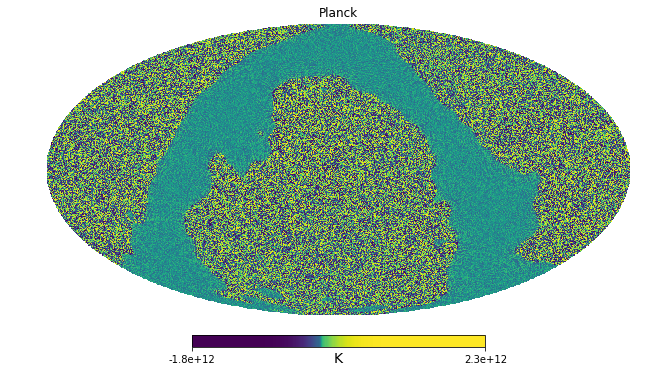

In [157]:
hp.mollview(cmbmap, nest=False, title="Planck", \
             unit = 'K', norm='hist', format='%.2g')




### Cross correlation with CMASS SGC

In [391]:
#random = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')
#random_ngc = esutil.io.read(path+'random0_DR12v5_CMASS_North.fits.gz')

In [392]:
#boss_sgc_map = making_healpix_density_map_boss(cat = random, nside = 4096, nest = False)
#boss_ngc_map = making_healpix_density_map_boss(cat = random_ngc, nside = 4096, nest = False)

#fitsio.write('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_4096.fits', boss_sgc_map)
#fitsio.write('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_4096.fits', boss_ngc_map)


In [183]:
#CMASS SGC
path = '/n/des/lee.5922/data/cmass_cat/'
cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
cmass_sgc_map = making_healpix_density_map(cat = cmass_sgc, nside = NSIDE, nest = False)
cmass_ngc_map = making_healpix_density_map(cat = cmass_ngc, nside = NSIDE, nest = False)
#cmass = boss_mask(cat=cmass, nside_out =NSIDE, area='SGC')
#cmass_ngc = boss_mask(cat=cmass_ngc, nside_out = NSIDE, area='NGC')

#random = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')
#random_ngc = esutil.io.read(path+'random0_DR12v5_CMASS_North.fits.gz')

Ntot 230831
mean Ngal 1.1914473005058326
Npix 193740
Ntot 618806
mean Ngal 1.1851932719674247
Npix 522114


In [188]:
cmass_sgc_map

array([( 45.,  89.95431464, 0.0000000e+00, 0., 0, -1.),
       (135.,  89.95431464, 1.0000000e+00, 0., 0, -1.),
       (225.,  89.95431464, 2.0000000e+00, 0., 0, -1.), ...,
       (135., -89.95431464, 1.2582909e+07, 0., 0, -1.),
       (225., -89.95431464, 1.2582910e+07, 0., 0, -1.),
       (315., -89.95431464, 1.2582911e+07, 0., 0, -1.)],
      dtype=[('RA', '<f8'), ('DEC', '<f8'), ('PIXEL', '<f8'), ('N_GAL', '<f8'), ('WEIGHT', '<i8'), ('KAPPA', '<f8')])

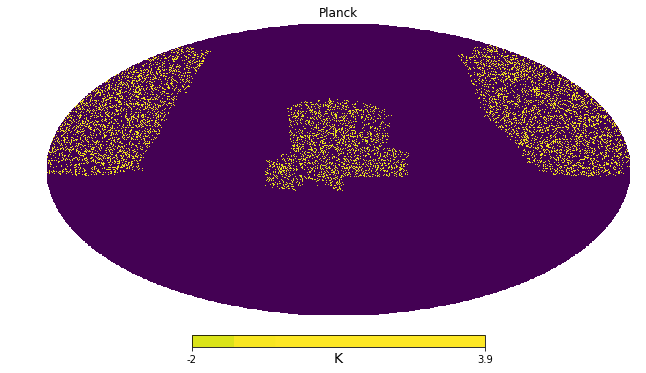

In [193]:
hp.mollview(cmass_sgc_map['KAPPA'] + cmass_ngc_map['KAPPA'], nest=False, title="Planck", \
             unit = 'K', norm='hist', format='%.2g')

In [394]:
#hp.mollview(cmass_ngc_galmap['WEIGHT'] ,
#            nest=False, title="CMASS NGC", 
#            norm='hist')

#hp.mollview(cmass_sgc_galmap['KAPPA'] ,
#            nest=False, title="CMASS SGC", 
#            norm='hist', min = -1, max=20000)

#hp.mollview(dmass_galmap['KAPPA'] ,
#            nest=False, title="DMASS SPT", 
#            norm='hist', min = -1, max=20000)



In [395]:
# HEALPIX MASK FOR ALL DATA nside 512
#boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits')
#boss_hpmask = np.zeros(hp.nside2npix(1024), dtype = 'bool')
#boss_hpmask[boss_hpind] = 1

#cmbmap_hpmask = reliable_hp_mask.copy()
#cmbmask_hpind = np.arange(hp.nside2npix(1024))#[cmbmap_hpmask]

#boss_cmbmask = (~boss_hpmask) * cmbmap_hpmask
#boss_cmbmask_hpind = np.arange(hp.nside2npix(1024))[boss_cmbmask]
#cmbmap_512[~boss_cmbmask] = -1.6375e+30

#LSSGoldmask = fitsio.read('/n/des/lee.5922/data/systematic_maps/Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
#LSSGoldmask = LSSGoldmask[LSSGoldmask['DEC'] < -3.0]
#spt_hpmap =  np.zeros(hp.nside2npix(4096))
#spt_hpmap[LSSGoldmask['PIXEL']] = LSSGoldmask['FRAC']
#spt_hpmap_512 = hp.ud_grade(spt_hpmap, nside_out = 1024)
#spt_hpmask = spt_hpmap_512 < 0.8

#spt_cmbmask = spt_hpmask * cmbmap_hpmask
#spt_cmbmask_hpind = np.arange(hp.nside2npix(1024))[spt_cmbmask]

In [396]:
#cmb_cmass = cmbmap_512.copy()
#cmb_cmass[boss_cmbmask] =  -1.6375e+30
#cmb_spt = cmbmap_512.copy()
#cmb_spt[spt_cmbmask] = -1.6375e+30

In [135]:



#cmb_spt = Cuts.keepGoodRegion(cmb_hpmap)
#cmb_spt = cmb_spt[cmb_spt['DEC'] < -3]

#cmb_sgc_cmass = boss_mask(cat=cmb_hpmap, nside_out =NSIDE, area='SGC')
#cmb_ngc_cmass = boss_mask(cat=cmb_hpmap, nside_out = NSIDE, area='NGC')

#cmb_cmass_random = boss_mask(cat = uniform_random_on_sphere(cmb_cmass, size = cmb_cmass.size * 10 ), area = 'SGC')
#cmb_ngc_cmass_random = boss_mask(cat = uniform_random_on_sphere(cmb_cmass, size = cmb_cmass.size * 10 ), area = 'NGC')


(3145728,) 3145728 (3145728,)


In [137]:
dmass_spt = esutil.io.read('../output/n2_2/dmass_spt.fits')
#dmass_spt = y1gold_mask(cat = dmass_spt, nside_out = NSIDE)
dmass_galmap= making_healpix_density_map(cat = dmass_spt, nside = NSIDE, nest = False)
#dmass_random = Cuts.keepGoodRegion(uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 30 ))
#cmb_random = Cuts.keepGoodRegion(uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 30 ))

Ntot 112398
mean Ngal 1.9460498294579012
Npix 57757


In [399]:
#cmass_ngc_galmap_masked = boss_mask(cat=cmass_ngc_galmap, nside_out = NSIDE, area='NGC')
#cmass_sgc_galmap_masked = boss_mask(cat=cmass_sgc_galmap, nside_out=NSIDE, area='SGC')

#dmass_galmap_masked = Cuts.keepGoodRegion(dmass_galmap)
#dmass_galmap_masked = dmass_galmap_masked[dmass_galmap_masked['DEC'] < -3]

In [171]:
from systematics_module.corr import cross_kg_correlation, cross_angular_correlation, _cross_kg_acf

In [198]:
meanr, xi, xi_err = _cross_kg_acf(cmass_ngc_map, cmb_hpmap, weight = True, kappa = True)

.


In [204]:
cmb_ngc['KAPPA']

array([-8.00925030e+16, -3.20961120e+17, -1.16170057e+17, ...,
        1.03700731e+17, -1.95273019e+17,  3.83885021e+16])

In [206]:
import treecorr
cat = treecorr.Catalog(ra=cmass_ngc['RA'], dec=cmass_ngc['DEC'], w = None, ra_units='deg', dec_units='deg')
cat2 = treecorr.Catalog(ra=cmb_ngc['RA'], dec=cmb_ngc['DEC'], k= cmb_ngc['KAPPA'], ra_units='deg', dec_units='deg')

nbins = 20
min_sep = 1
max_sep  = 100
sep_units = 'degree'

nk = treecorr.NKCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units)

nk.process(cat, cat2)
xi, varxi = nk.calculateXi()
meanr = nk.meanr

.


In [195]:
dir = '../data_txt/'
#cmass_ngc_galmap_masked = boss_mask(cat=cmass_ngc_galmap[cmbTmask], area='NGC')
cross_kg_correlation(data = cmass_ngc_map, 
                     data2 = cmb_hpmap, njack = 20,  
                     weight = True, kappa=True, suffix = '_cmb_lensing_x_cmass_ngc_hp_nside1024', dir=dir)
"""

cross_kg_correlation(data = cmass_sgc, 
                     data2 = cmb_sgc, njack = 20,  
                     weight = None, kappa=True, suffix = '_cmb_lensing_x_cmass_sgc_hp_nside1024',dir=dir)
"""

#cmass_sgc_galmap_masked = boss_mask(cat=cmass_sgc_galmap[cmbTmask], area='SGC')

"""

cross_kk_correlation(data = cmass_sgc_galmap, 
                     weight1 = True, weight2 = True,
                     data2 = cmb_hpmap, njack = 30,  
                     kappa1 = True, kappa2=True, mpi=True, suffix = '_cmb_x_cmass_sgc_hp_nside512')


#dmass_galmap_masked = Cuts.keepGoodRegion(dmass_galmap[cmbTmask])
#dmass_galmap_masked = dmass_galmap_masked[dmass_galmap_masked['DEC'] < -3]
cross_kk_correlation(data = dmass_galmap, 
                     weight1 = True, weight2 = True,
                     data2 = cmb_hpmap, njack = 30,  
                     kappa1 = True, kappa2=True, mpi=True, suffix = '_cmb_x_dmass_hp_nside512')
"""


X (7094, 2)  centers (20, 2)  tol=1e-05  maxiter=200
26 iterations  cluster sizes: [338 368 345 352 369 313 306 409 329 326 349 404 358 334 390 335 385 354
 353 377]
X (12582912, 2)  centers (20, 2)  tol=1e-05  maxiter=200


KeyboardInterrupt: 

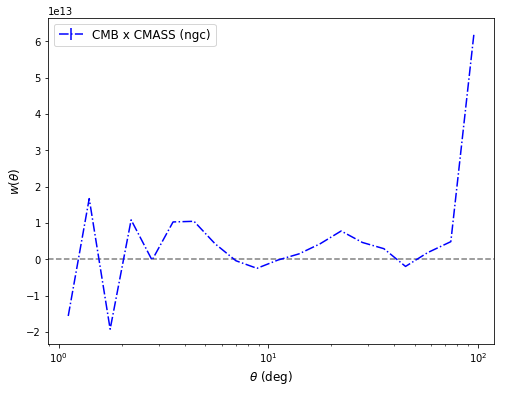

In [207]:
DAT = np.loadtxt('../data_txt/acf_cross_kg_cmb_lensing_x_cmass_ngc_hp_nside1024.txt')
#meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('../data_txt/acf_cross_kg_cmb_lensing_x_cmass_sgc_hp_nside1024.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('../data_txt/acf_cross_kk_cmb_x_dmass_hp_nside256.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
#meanr = np.logspace(np.log(50/60.), np.log(1000/60.), 30)
ax.errorbar(meanr*0.98, xi, yerr = 1, fmt = '-.b', label='CMB x CMASS (ngc)')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='CMB x CMASS (sgc)' )
#ax.errorbar(meanr3*1.02, xi3, yerr = xi_err3, fmt = '.g', label='CMB x DMASS')

#chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
#chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size
#print chisqr, chisqr3

#ax.text(1.2, 0.008, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.006, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
#ax.set_ylim(-1.5, 2.)
#ax.set_xlim(50/60., 12)


(0.8333333333333334, 12)

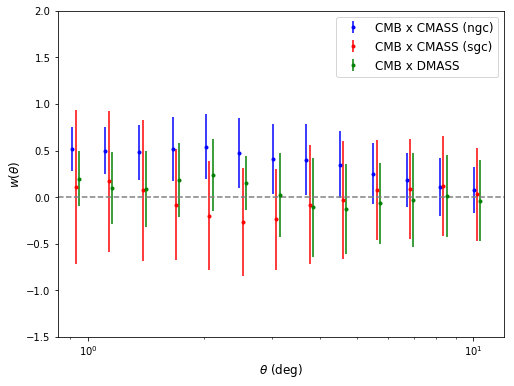

In [401]:
DAT = np.loadtxt('data_txt/acf_cross_kk_cmb_x_cmass_ngc_hp_nside512.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_cmb_x_cmass_sgc_hp_nside512.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_cmb_x_dmass_hp_nside512.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
#meanr = np.logspace(np.log(50/60.), np.log(1000/60.), 30)
ax.errorbar(meanr*0.98, xi, yerr = xi_err, fmt = '.b', label='CMB x CMASS (ngc)')
#ax.errorbar(rr, xi, yerr = varxi, fmt = '.b', label='CMB x cmass(sgc)')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='CMB x CMASS (sgc)' )
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3*1.02, xi3, yerr = xi_err3, fmt = '.g', label='CMB x DMASS')

#chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
#chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size
#print chisqr, chisqr3

#ax.text(1.2, 0.008, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.006, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_ylim(-1.5, 2.)
ax.set_xlim(50/60., 12)


(0.8333333333333334, 12)

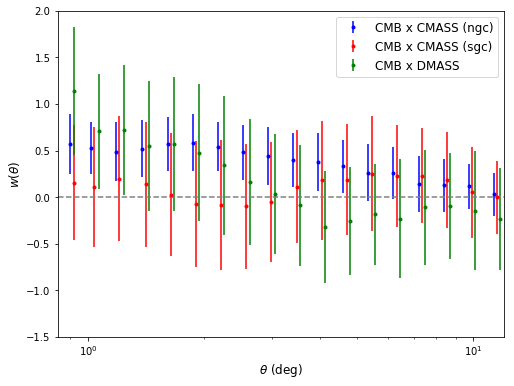

In [146]:
DAT = np.loadtxt('data_txt/acf_cross_kk_cmb_x_cmass_ngc_hp_no6.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_cmb_x_cmass_sgc_hp_no2.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_cmb_x_dmass_hp_no2.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
#meanr = np.logspace(np.log(50/60.), np.log(1000/60.), 30)
ax.errorbar(meanr*0.98, xi, yerr = xi_err, fmt = '.b', label='CMB x CMASS (ngc)')
#ax.errorbar(rr, xi, yerr = varxi, fmt = '.b', label='CMB x cmass(sgc)')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='CMB x CMASS (sgc)' )
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3*1.02, xi3, yerr = xi_err3, fmt = '.g', label='CMB x DMASS')

#chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
#chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size
#print chisqr, chisqr3

#ax.text(1.2, 0.008, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.006, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_ylim(-1.5, 2.)
ax.set_xlim(50/60., 12)


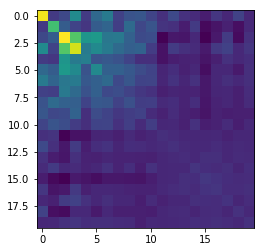

In [703]:
fig, ax = plt.subplots()
cov = np.genfromtxt('.cov_angular')
ax.imshow(cov)